In [1]:
import acquire
import prepare
import model

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from wordcloud import WordCloud
import scipy.stats as stats

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

Python, Java, C++

In [2]:
# DATA ACQUISITION: lists of repos for 3 different languages were generated

# acquire.get_repo_list(query='machine learning language:python', sort_method='stars', how_many = 50)

# acquire.get_repo_list(query='machine learning language:c++', how_many = 50)

# acquire.get_repo_list(query='machine learning language:java', how_many = 50)

In [3]:
# Data was scraped using the acquire script from Zach
# scraped_data = acquire.scrape_github_data()

# Scrapped data saved to dataframe and json
# data = pd.DataFrame(scraped_data)

# data.to_json('data.json')

In [4]:
# Read data from json into Pandas Dataframe
data = pd.read_json('data.json')

In [5]:
extra_words = ['see', 'source', 'example', 'code', 'use', '1', "'", ';', '&#9']
prepared_data = prepare.prepare_df(data, column =  'readme_contents', extra_words = extra_words)

In [6]:
# Calculates total length of readme based on number of characters
prepared_data['original_length'] = prepared_data.readme_contents.str.len()
prepared_data['stem_length'] = prepared_data.stemmed.str.len()
prepared_data['lem_length'] = prepared_data.lemmatized.str.len()

# Calculates total number of words (splitting up by whitespace)
prepared_data['original_word_count'] = prepared_data.readme_contents.str.split().str.len()
prepared_data['stemmed_word_count'] = prepared_data.stemmed.str.split().str.len()
prepared_data['lemmatized_word_count'] = prepared_data.lemmatized.str.split().str.len()

In [7]:
train, validate, test = prepare.train_validate_test_split(prepared_data, target = 'language')

### Is there a significant difference in the length of a README based on the language?

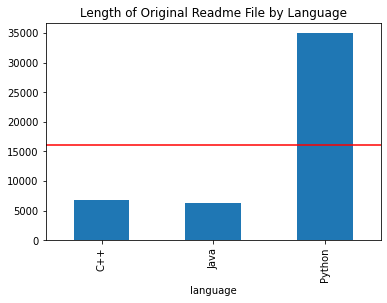

In [8]:
train.groupby('language').original_length.mean().plot.bar()
overall_mean_length_readme = train.original_length.mean()
plt.title('Length of Original Readme File by Language')
plt.axhline(overall_mean_length_readme, color = 'r')

In [9]:
# Perform 1 sample t-test comparing mean length of original README file per language to the overall average length (all languages)
# Set significance level to 0.05
alpha = 0.05
overall_mean_length_readme = train.original_length.mean()
for l in train.language.unique():
    sample = train[train.language == l]
    t,p = stats.ttest_1samp(sample.original_length, overall_mean_length_readme)
    print(l, round(t,5), p<alpha)

Java -10.17324 True
C++ -8.42402 True
Python 1.12877 False


Only Java and C++ show a statistically significant difference in original readme length from the overall mean. Clearly the length of the Python repo READMEs is much higher than the overall average. README length could be a valuable feature to add to the model.

### Are there differences in the number of words in a README based on language?

In [10]:
def generate_category_words(df, categorical = 'language'):
    """ Joins all words in each readme per language. Outputs dataframe with all_words by language.
    df: prepared data with a lemmatized column
    categorical: the category to split the data on"""
    
    category_words = {}
    
    # Get all words for lemmatized version of all articles in category
    for category in df[categorical].unique():
        sample = df[df[categorical] == category]
        cat_words = ' '.join(sample.lemmatized.apply(prepare.basic_clean))
        
        category_words[category] = cat_words
        
    category_words['all'] = ' '.join(df.lemmatized.apply(prepare.basic_clean))
        
    return pd.DataFrame(category_words, index = ['all_words']).T

In [11]:
all_words_df = generate_category_words(train)

In [12]:
def generate_word_count_df(all_words_df):
    """Generates a df with word counts by language. 
    Takes as argument all_words_df, which is every word from every document grouped by language,
    which was created with generate_category_words function."""
    
    # Split the text by whitespace which generates list of individual words, and counts frequency of word
    all_words_df = pd.concat([all_words_df, 
                              all_words_df['all_words'].apply(lambda words: pd.Series(words.split()).value_counts())],axis=1)
    
    # Transpose and fill NaN with 0
    all_words_df = all_words_df.T.fillna(0)
    
    # Drop the all_words row
    all_words_df = all_words_df.drop(all_words_df.index[0])
        
    return all_words_df

In [13]:
word_counts = generate_word_count_df(all_words_df)

In [14]:
word_counts

,Java,C++,Python,all
learning,98.0,75.0,366.0,539.0
training,92.0,30.0,72.0,194.0
dependency,90.0,32.0,16.0,138.0
machine,85.0,53.0,254.0,392.0
java,75.0,6.0,7.0,88.0
...,...,...,...,...
quants,0,0,1.0,1.0
researchhudsonthamesorg,0,0,1.0,1.0
srchttpshudsonthamesorgwpcontentuploads202111headergithubhtjpg,0,0,1.0,1.0
bridging,0,0,1.0,1.0


In [15]:
def plot_bigrams(df, category):
    """ Accepts all words dataframe and outputs plots of top 20 bigrams and wordcloud """
    # Generate bigrams
    bigrams = list(nltk.ngrams(all_words_df.T[category]['all_words'].split(),2))
    # Take top 20
    top_20_cat_bigrams = pd.Series(bigrams).value_counts().head(20)
    
    # Plot bar chart
    top_20_cat_bigrams.sort_values().plot.barh(color='orange', width=.9, figsize=(10, 6))
    
    # Ensure only integer values for x axis
    plt.xticks(range(top_20_cat_bigrams.sort_values().max()+1))

    plt.title(f'20 Most frequently occuring {category} bigrams')
    plt.ylabel('Bigram')
    plt.xlabel('# Occurrences')

    # make the labels pretty
    ticks, _ = plt.yticks()
    labels = top_20_cat_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
    _ = plt.yticks(ticks, labels)
    plt.show()
    
    # Plot wordcloud
    data = {k[0] + ' ' + k[1]: v for k, v in top_20_cat_bigrams.to_dict().items()}
    img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
    plt.figure(figsize=(8, 4))
    plt.imshow(img)
    plt.axis('off')
    plt.title(category)
    plt.show()

In [16]:
# for col in word_counts.columns[:]:
#     plot_bigrams(all_words_df, col)
#     plt.show()

In [17]:
# def model_words(vectorizer, class_model, ngrams_range_value, train, validate, target, print_results = True):
#     """Performs classification modeling of lemmatized data. Outputs (and returns) classification reports for train and validate/test.
    
#     vectorizer: the type of feature extraction method, such as Count Vectorizer or tf-idf
#     class_model: the classification model to use
#     ngrams_range_value: whether to use unigram, bigrams, etc. for the feature extraction
#     train and test sets as well as the target variable"""
    
#     # Instantiate the feature extraction method
#     feature_extraction_method = vectorizer(ngram_range=ngrams_range_value)
    
#     # Instantiate scaler
#     scaler = StandardScaler()
    
#     # Perform feature extraction on lemmatized text from train
#     X_train = feature_extraction_method.fit_transform(train.lemmatized)
    
#     # Generate dataframe of results of feature extraction
#     train_vectorizer_df = pd.DataFrame(X_train.todense(), columns=feature_extraction_method.get_feature_names_out())
    
#     # Set index to train index
#     train_vectorizer_df.index = train.index
    
#     # Add in other features (lengths of readme)
#     X_train = pd.concat([train_vectorizer_df,train[['original_length','stem_length', 'lem_length', 'original_word_count',
#            'stemmed_word_count', 'lemmatized_word_count']]], axis = 1)
    
#     # Scale features in train (necessary for logistic regression)
#     X_train_scaled = scaler.fit_transform(X_train)
    
#     # Perform feature extraction and add in additional features on validate
#     X_validate = feature_extraction_method.transform(validate.lemmatized)
#     validate_vectorizer_df = pd.DataFrame(X_validate.todense(), columns=feature_extraction_method.get_feature_names_out())
#     validate_vectorizer_df.index = validate.index

#     X_validate = pd.concat([validate_vectorizer_df,validate[['original_length','stem_length', 'lem_length', 'original_word_count',
#            'stemmed_word_count', 'lemmatized_word_count']]], axis = 1)
    
#     # Scale validate
#     X_validate_scaled = scaler.transform(X_validate)
    
#     # Define target 
#     y_train = train[target]
#     y_validate = validate[target]
    
#     # Create dataframe of results from train and validate
#     train_results=pd.DataFrame(dict(actual = y_train))
#     validate_results = pd.DataFrame(dict(actual = y_validate))
    
#     # Check if Logistic regression model being used, which requires scaled data
#     if ('Logistic' in class_model.__repr__()):
        
#         # Fit model to scaled train data 
#         model_to_use = class_model.fit(X_train_scaled, y_train)
        
#         # Predict on train and validate
#         train_results['predicted'] = model_to_use.predict(X_train_scaled)
#         validate_results['predicted'] = model_to_use.predict(X_validate_scaled)
        
#         # Feature names and importances not available for Logistic Regression
#         feature_names = [np.nan]
#         feature_importances = [np.nan]      
#     else:
#         # Tree based models do not need scaled data
#         model_to_use = class_model.fit(X_train, y_train)

#         train_results['predicted'] = model_to_use.predict(X_train)
#         validate_results['predicted'] = model_to_use.predict(X_validate)
        
#         # Multinormal Naive Bayes do not have feature names or importances available. Other algorithms do and will be saved.
#         if ('MultinomialNB' not in class_model.__repr__()):
#             feature_names = feature_extraction_method.get_feature_names_out()
#             feature_importances = model_to_use.feature_importances_
#         else:
#             # Feature names and importances not available for Multinomial Naive Bayes
#             feature_names = [np.nan]
#             feature_importances = [np.nan]   
            
#     # Generate classification reports for train and validate
#     train_class_report = classification_report(train_results.actual, train_results.predicted, output_dict = True)
#     validate_class_report = classification_report(validate_results.actual, validate_results.predicted,output_dict=True)
    
#     # Print results from predictions
#     if print_results:
#         print('Accuracy: {:.2%}'.format(accuracy_score(train_results.actual, train_results.predicted)))
#         print('---')
#         # print('Train Confusion Matrix')
#         # print(pd.crosstab(train_results_tfidf.predicted, train_results_tfidf.actual))
#         print('---')
#         print(pd.DataFrame(train_class_report))


#         print('Accuracy: {:.2%}'.format(accuracy_score(validate_results.actual, validate_results.predicted)))
#         print('---')
#         # print('Validate Confusion Matrix')
#         # print(pd.crosstab(validate_results_tfidf.predicted, validate_results_tfidf.actual))
#         print('---')
#         print(pd.DataFrame(validate_class_report))
    
#     return train_class_report, validate_class_report, feature_names, feature_importances

### Baseline would be 33%, as we know there are 3 different languages in the dataset and they are evenly distributed.

In [18]:
target = 'language'
vectorizers = [CountVectorizer, TfidfVectorizer]
class_models = [MultinomialNB(), 
                RandomForestClassifier(random_state=123, max_depth = 5), 
                LogisticRegression(C=0.01),
                LogisticRegression(C=0.1),
                LogisticRegression(C=1.0),
                DecisionTreeClassifier(max_depth=5)]
# Establish range of ngrams to use - (1,2) means use both unigrams and bigrams
ngram_range_values = [(1,1),(1,2),(2,2),(1,3),(2,3)]
print_results_param = False




In [24]:
results = model.model_multiple(vectorizers, class_models, ngram_range_values, train, validate, target, print_results_param)

In [39]:
class_models = [RandomForestClassifier(random_state=123, max_depth = 2), 
                DecisionTreeClassifier(max_depth=2),
               RandomForestClassifier(random_state=123, max_depth = 1), 
                DecisionTreeClassifier(max_depth=1)]

In [40]:
results2 = model.model_multiple(vectorizers, class_models, ngram_range_values, train, validate, target, print_results_param)

In [43]:
results2.sort_values(by=['validate_accuracy','dropoff'], ascending = [False, True]).head()

,model_parameters,train_accuracy,validate_accuracy,dropoff,feature_names,feature_importances,top_features
"(TfidfVectorizer, RandomForestClassifier, (1, 1))","{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.904762,0.666667,0.238095,"[00, 000000true, 0001, 0003, 001, 0016666, 004...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[graph, java, experiment, text, built, matplot..."
"(TfidfVectorizer, RandomForestClassifier, (1, 1))","{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.952381,0.666667,0.285714,"[00, 000000true, 0001, 0003, 001, 0016666, 004...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[license, clustering, text, built, java, matpl..."
"(CountVectorizer, DecisionTreeClassifier, (1, 1))","{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.690476,0.638889,0.051587,"[00, 000000true, 0001, 0003, 001, 0016666, 004...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[github580, githubhttpsaifacebookcomblogusingn..."
"(CountVectorizer, DecisionTreeClassifier, (1, 2))","{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.690476,0.638889,0.051587,"[00, 00 either, 00 emptyserverformhandler, 00 ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[else model, else, email, 26, regression, java]"
"(CountVectorizer, DecisionTreeClassifier, (1, 3))","{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.690476,0.638889,0.051587,"[00, 00 either, 00 either realtime, 00 emptyse...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[dropout regularisation great, dropcolumn code..."


60 models were evaluated with the following options:
- Vectorizers: count vectorizer and tf-idf
- Models:
    - Multinomial Naive Bayes with default hyperparameters
    - Random Forest classifier with max depth of 5
Top model based on highest accuracy on validate and least dropoff in performance from train to validate is the decision tree classifier using unigrams, bigrams, and trigrams. 

In [32]:
results

,model_parameters,train_accuracy,validate_accuracy,dropoff,feature_names,feature_importances,top_features
"(CountVectorizer, DecisionTreeClassifier, (1, 3))","{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.928571,0.666667,0.261905,"[00, 00 either, 00 either realtime, 00 emptyse...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[usage, fastest, gpu, aligncenter, regression,..."
"(TfidfVectorizer, RandomForestClassifier, (1, 1))","{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.964286,0.638889,0.325397,"[00, 000000true, 0001, 0003, 001, 0016666, 004...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[python, either, pip, scientific, matplotlib, ..."
"(TfidfVectorizer, LogisticRegression, (1, 1))","{'C': 0.01, 'class_weight': None, 'dual': Fals...",1.000000,0.638889,0.361111,[nan],[nan],NaN
"(TfidfVectorizer, LogisticRegression, (1, 1))","{'C': 0.1, 'class_weight': None, 'dual': False...",1.000000,0.638889,0.361111,[nan],[nan],NaN
"(TfidfVectorizer, LogisticRegression, (2, 2))","{'C': 0.1, 'class_weight': None, 'dual': False...",1.000000,0.638889,0.361111,[nan],[nan],NaN
"(TfidfVectorizer, LogisticRegression, (2, 2))","{'C': 1.0, 'class_weight': None, 'dual': False...",1.000000,0.638889,0.361111,[nan],[nan],NaN
"(TfidfVectorizer, DecisionTreeClassifier, (1, 3))","{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.916667,0.611111,0.305556,"[00, 00 either, 00 either realtime, 00 emptyse...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[40, page, stack, aligncenter, coverage, java]"
"(CountVectorizer, RandomForestClassifier, (1, 1))","{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.952381,0.611111,0.341270,"[00, 000000true, 0001, 0003, 001, 0016666, 004...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[clustering, build, java, matplotlib, import, ..."
"(TfidfVectorizer, RandomForestClassifier, (1, 3))","{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.952381,0.611111,0.341270,"[00, 00 either, 00 either realtime, 00 emptyse...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[license, stack, method, pip, algorithm, java]"
"(TfidfVectorizer, RandomForestClassifier, (1, 2))","{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.964286,0.611111,0.353175,"[00, 00 either, 00 emptyserverformhandler, 00 ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[logistic regression, java, result, instructio..."


In [20]:
# # Generate dataframe of results from modeling
# results = pd.DataFrame(data = {'model_parameters': model_parameters,
#                                'train_accuracy':train_accuracies,
#                                'validate_accuracy':validate_accuracies,
#                                'dropoff': dropoffs,
#                               'feature_names':feature_names_list,
#                               'feature_importances':feature_importances_list}, 
#                        index=indices).sort_values(['dropoff', 'validate_accuracy'])

# def get_top_features(row, n):
#     """Outputs a list of the top n features used for the modeling"""
#     if len(row.feature_names)<10:
#         return np.NaN
#     else:
#         return pd.Series(dict(zip(row.feature_names, row.feature_importances))).sort_values().tail(n).index.tolist() 

# results['top_features'] = results.apply(lambda row: get_top_features(row, 6), axis=1)

# results.sort_values(by=['validate_accuracy','dropoff'], ascending=[False,True]).head(20)

In [21]:
# target = 'language'
# vectorizers = [CountVectorizer]#, TfidfVectorizer]
# class_models = [RandomForestClassifier(random_state=123)]#, LogisticRegression(), DecisionTreeClassifier(), DecisionTreeClassifier(max_depth=5)]
# ngram_range_values = [(1,1)]#,(1,2),(2,2),(1,3),(2,3)]
# print_results = True

In [22]:
# feature_extraction_method = vectorizers[0](ngram_range=ngram_range_values[0])

# X_train = feature_extraction_method.fit_transform(train.lemmatized)
# train_vectorizer_df = pd.DataFrame(X_train.todense(), columns=feature_extraction_method.get_feature_names_out())
# train_vectorizer_df.index = train.index

# X_train = pd.concat([train_vectorizer_df,train[['original_length','stem_length', 'lem_length', 'original_word_count',
#        'stemmed_word_count', 'lemmatized_word_count']]], axis = 1)

# X_validate = feature_extraction_method.transform(validate.lemmatized)
# validate_vectorizer_df = pd.DataFrame(X_validate.todense(), columns=feature_extraction_method.get_feature_names_out())
# validate_vectorizer_df.index = validate.index

# X_validate = pd.concat([validate_vectorizer_df,validate[['original_length','stem_length', 'lem_length', 'original_word_count',
#        'stemmed_word_count', 'lemmatized_word_count']]], axis = 1)

# X_test = feature_extraction_method.transform(test.lemmatized)
# y_train = train[target]
# y_validate = validate[target]
# # y_test = test[target]

# # X_train = pd.DataFrame(X_train.todense(), columns=feature_extraction_method.get_feature_names_out())

# train_results=pd.DataFrame(dict(actual = y_train))
# validate_results = pd.DataFrame(dict(actual = y_validate))
# # test_results = pd.DataFrame(dict(actual = y_test))

# model_to_use = class_models[0].fit(X_train, y_train)

# train_results['predicted'] = model_to_use.predict(X_train)
# validate_results['predicted'] = model_to_use.predict(X_validate)

# if type(class_models[0]).__name__ != 'LogisticRegression':
#     feature_names = feature_extraction_method.get_feature_names_out()
#     feature_importances = model_to_use.feature_importances_
# else:
#     feature_names = [np.nan]
#     feature_importances = [np.nan]    

# train_class_report = classification_report(train_results.actual, train_results.predicted, output_dict = True)
# validate_class_report = classification_report(validate_results.actual, validate_results.predicted,output_dict=True)

# if print_results:
#     print('Accuracy: {:.2%}'.format(accuracy_score(train_results.actual, train_results.predicted)))
#     print('---')
#     # print('Train Confusion Matrix')
#     # print(pd.crosstab(train_results_tfidf.predicted, train_results_tfidf.actual))
#     print('---')
#     print(pd.DataFrame(train_class_report))


#     print('Accuracy: {:.2%}'.format(accuracy_score(validate_results.actual, validate_results.predicted)))
#     print('---')
#     # print('Validate Confusion Matrix')
#     # print(pd.crosstab(validate_results_tfidf.predicted, validate_results_tfidf.actual))
#     print('---')
#     print(pd.DataFrame(validate_class_report))